In [2]:
# Import needed libraries 
import pandas as pd 
import os
from datetime import timedelta
import numpy as np 
from scipy.signal import argrelextrema
import alpaca_trade_api as tradeapi 
import matplotlib.pyplot as plt 
import matplotlib.dates as mpdates
from mplfinance.original_flavor import candlestick_ohlc
from dotenv import load_dotenv

In [3]:
#Load .env environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# Set Alpaca API key and secret
APCA_API_KEY_ID = os.getenv("APCA_API_KEY")
APCA_API_SECRET_KEY = os.getenv("APCA_SECRET_KEY")
ALPACA_ENDPOINT_KEY = os.getenv("ALPACA_END_POINT")

#ensuring api keys are correct 
#print(os.getenv("APCA_API_KEY_ID"))
#print(os.getenv("APCA_API_SECRET_KEY"))
#print(os.getenv("ALPACA_ENDPOINT_KEY"))

# Create the Alpaca API object
api = tradeapi.REST(APCA_API_KEY_ID, APCA_API_SECRET_KEY, api_version="v2",base_url= ALPACA_ENDPOINT_KEY)

In [11]:
# Set the ticker
ticker = "QQQ"

# Set timeframe to "1 Minute"
timeframe = "1Min"

# Set start and end datetimes of 3 years from Today
start_date = pd.Timestamp("2021-01-21", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-01-28", tz="America/New_York").isoformat()

# Get 3 years worth of historical data for TSLA
ticker_data = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
).df

display(ticker_data.head())
display(ticker_data.tail())

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-21 09:00:00+00:00,325.28,325.28,325.28,9,325.28,402,325.306219
2021-01-21 09:01:00+00:00,325.50,325.53,325.46,15,325.46,1326,325.493997
2021-01-21 09:02:00+00:00,325.52,325.60,325.51,35,325.54,4958,325.535841
2021-01-21 09:03:00+00:00,325.60,325.60,325.51,8,325.51,1139,325.584267
2021-01-21 09:04:00+00:00,325.51,325.55,325.51,4,325.55,219,325.529726


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-28 00:55:00+00:00,317.06,317.12,316.99,37,316.99,7388,317.046328
2021-01-28 00:56:00+00:00,317.11,317.12,317.11,11,317.12,1900,317.111053
2021-01-28 00:57:00+00:00,317.19,317.23,317.15,36,317.15,7653,317.173971
2021-01-28 00:58:00+00:00,317.24,317.24,317.20,19,317.22,1035,317.221333
2021-01-28 00:59:00+00:00,317.20,317.21,317.15,30,317.21,3538,317.174946


In [12]:
#dropping trade_count and vwap column
updated_ticker_data = ticker_data.drop(columns=['trade_count', 'vwap'])

#checking results
updated_ticker_data

,close,high,low,open,volume
timestamp,,,,,
2021-01-21 09:00:00+00:00,325.28,325.28,325.28,325.28,402
2021-01-21 09:01:00+00:00,325.50,325.53,325.46,325.46,1326
2021-01-21 09:02:00+00:00,325.52,325.60,325.51,325.54,4958
2021-01-21 09:03:00+00:00,325.60,325.60,325.51,325.51,1139
2021-01-21 09:04:00+00:00,325.51,325.55,325.51,325.55,219
...,...,...,...,...,...
2021-01-28 00:55:00+00:00,317.06,317.12,316.99,316.99,7388
2021-01-28 00:56:00+00:00,317.11,317.12,317.11,317.12,1900
2021-01-28 00:57:00+00:00,317.19,317.23,317.15,317.15,7653


In [13]:
# Convert the index to datetime
updated_ticker_data.index = pd.to_datetime(updated_ticker_data.index)

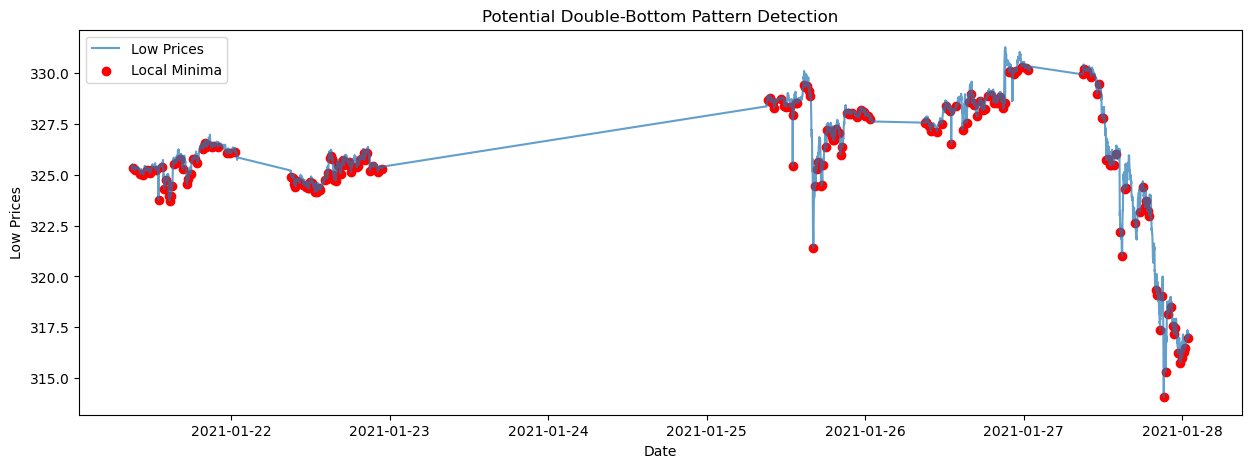

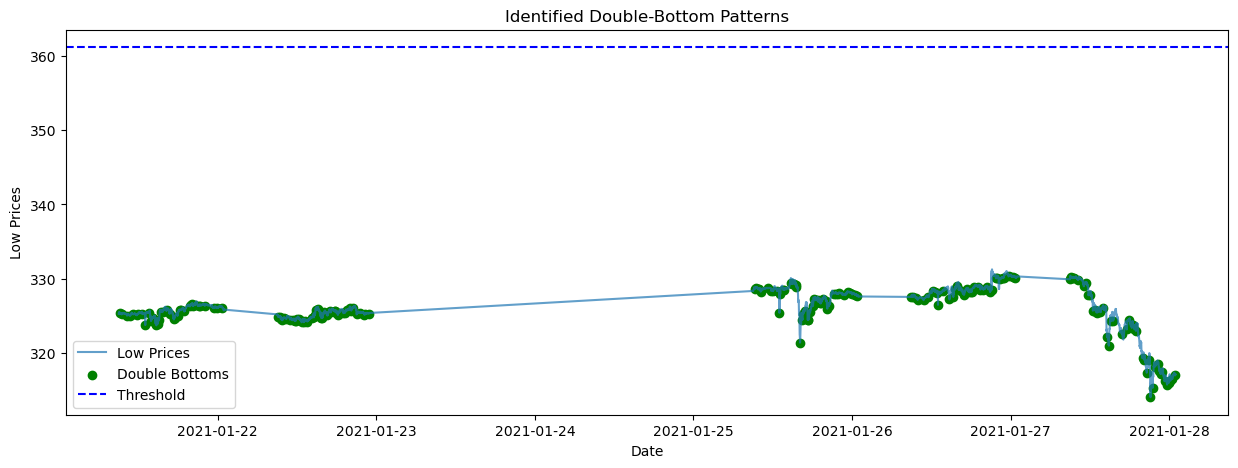

In [14]:
# Calculate the lows for potential double-bottom pattern detection
lows = updated_ticker_data['low']

# Find local minima indices using scipy's argrelextrema
minima_indices = argrelextrema(lows.values, np.less, order=5)[0]

# Plot the stock data and identified minima
plt.figure(figsize=(15, 5))
plt.plot(updated_ticker_data.index, lows, label='Low Prices', alpha=0.7)
plt.scatter(updated_ticker_data.index[minima_indices], lows.iloc[minima_indices], color='red', label='Local Minima')
plt.title('Potential Double-Bottom Pattern Detection')
plt.xlabel('Date')
plt.ylabel('Low Prices')
plt.legend()
plt.show()

# Define parameters for double-bottom pattern detection
y_delta = 0.03  # Adjust as needed
threshold = lows.min() * 1.15

# Identify potential double-bottom patterns
suspected_bottoms = []
for index in minima_indices:
    avg_price = lows.iloc[max(0, index - 5): min(len(lows), index + 5)].mean()
    if lows.iloc[index] < threshold:
        suspected_bottoms.append(index)

# Plot the identified double-bottom patterns
plt.figure(figsize=(15, 5))
plt.plot(updated_ticker_data.index, lows, label='Low Prices', alpha=0.7)
plt.scatter(updated_ticker_data.index[suspected_bottoms], lows.iloc[suspected_bottoms], color='green', label='Double Bottoms')
plt.axhline(threshold, linestyle='--', color='blue', label='Threshold')
plt.title('Identified Double-Bottom Patterns')
plt.xlabel('Date')
plt.ylabel('Low Prices')
plt.legend()
plt.show()
